# Importing Libraries

In [ ]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob

# Reading and unzipping the CSV File

Images came from kaggle, others are uploaded via machine\


In [ ]:
# the path to the image data
RSNA_512_path = '/kaggle/input/rsna-breast-cancer-512-pngs'

In [ ]:
# Read the csv data.
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
# the number of total patients
len(df_train)

54706

In [ ]:
# the number of patients having implant
len(df_train[df_train['implant'] == 1])

1477

In [ ]:
# the number of patients without malignant cancer
len(df_train[df_train['cancer'] == 0])

53548

In [ ]:
# the number of patient who took biopsy
len(df_train[df_train['biopsy'] == 1])

2969

In [ ]:
# the number of patients having malignant cancer
len(df_train[df_train['cancer'] == 1])

1158

In [ ]:
# the number of patients whose malignant cancer is invasive
len(df_train[df_train['invasive'] == 1])

818

In [ ]:
# the same as above
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

818

<AxesSubplot:xlabel='class', ylabel='count'>

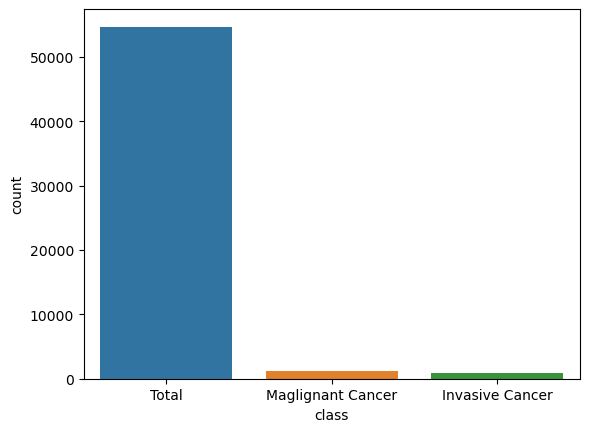

In [ ]:
# Most of the cases are normal or not-malignant cancer. Thus, physicians sometimes overlook cancer.
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<AxesSubplot:xlabel='class', ylabel='count'>

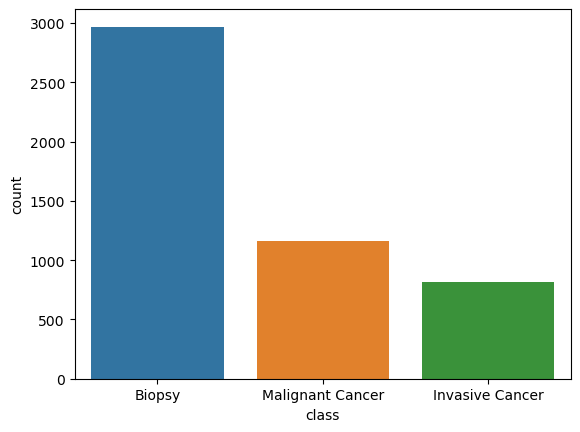

In [ ]:
# Around 3000 patient took biopsy and malignant cancer was found from some of them.
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [ ]:
# the number of not-malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [ ]:
# the number of malignant cancer cases from biopsy
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<AxesSubplot:xlabel='class', ylabel='count'>

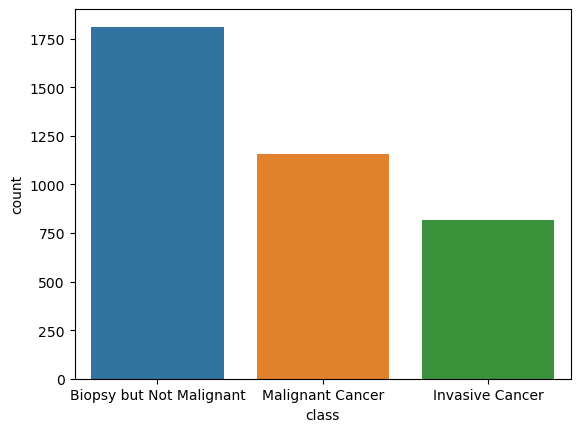

In [ ]:
# 60% of biopsy resulted in not-malignanct cancer.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [ ]:
# The not-malignant cancer cases were limited into biopsy cases.
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [ ]:
# The number of positive (malignant) and negative (not-malignat) cases should be the same
# to create a balanced dataset.
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

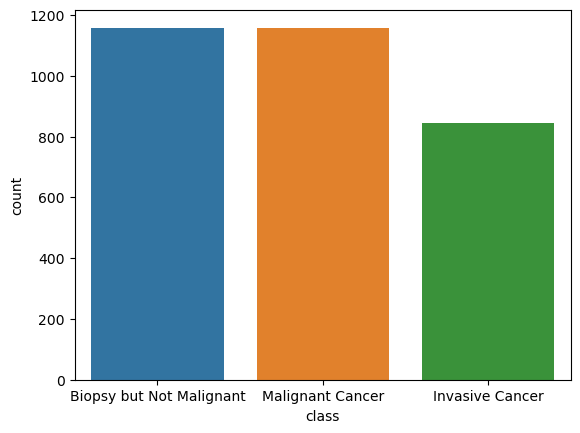

In [ ]:
# Generally, invasive cancer is confirmed by biopsy, not by mammography.
# Maybe it is also extremely difficult for AI to detect invasive cancer from mammography.
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

# Create the Path to Each Image

In [ ]:
# Create the path to each image.
for i in range(len(DF_train)):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(DF_train.loc[i, 'patient_id']) + '_' + str(DF_train.loc[i, 'image_id']) + '.png')
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,46576,1039748459,L,MLO,57.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4657...
1,1,12919,1342875479,R,MLO,52.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1291...
2,1,1710,1861682438,R,MLO,46.0,0,1,0,0.0,0,A,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1710...
3,1,41219,27338484,L,MLO,51.0,0,1,0,0.0,1,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4121...
4,1,27825,234287133,R,CC,60.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2782...


In [ ]:
# a sample path
DF_train.loc[0, 'path']

'/kaggle/input/rsna-breast-cancer-512-pngs/46576_1039748459.png'

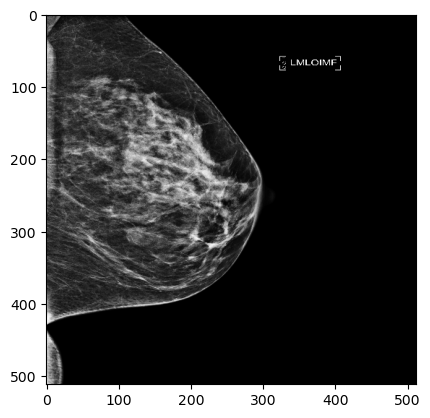

In [ ]:
# a sample image
img = cv2.imread(DF_train.loc[0, 'path'])
plt.imshow(img, cmap = 'gray')

In [ ]:
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[223, 223, 223],
        [218, 218, 218],
        [204, 204, 204],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[218, 218, 218],
        [216, 216, 216],
        [215, 215, 215],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[226, 226, 226],
        [222, 222, 222],
        [222, 222, 222],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
img.shape

(512, 512, 3)

# Separating the data into Train and Validation

In [ ]:
# Normal and cancer images must be equally distrubuted.
train_df, val_df = train_test_split(DF_train, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = DF_train[['cancer']])

print('train', train_df.shape[0], 'validation', val_df.shape[0])
print('train', train_df['cancer'].value_counts())
print('validation', val_df['cancer'].value_counts())
train_df.sample(1)

train 1621 validation 695
train 1    811
0    810
Name: cancer, dtype: int64
validation 0    348
1    347
Name: cancer, dtype: int64


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1312,1,21315,842119228,R,MLO,71.0,1,1,0,0.0,0,C,93,False,/kaggle/input/rsna-breast-cancer-512-pngs/2131...


In [ ]:
# training data
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
2110,2,55842,115057946,L,MLO,73.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/5584...
1564,2,32527,701842729,R,MLO,74.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3252...
553,2,826,668064372,R,CC,68.0,0,1,0,NaN,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-512-pngs/826_...
757,1,12714,354738951,R,MLO,69.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1271...
1873,1,53343,1721695713,L,MLO,77.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5334...


In [ ]:
# validation data
val_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
763,1,2083,1775123300,R,CC,41.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2083...
933,1,5804,132577031,L,CC,49.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5804...
493,1,51264,1695248964,R,MLO,41.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5126...
2145,1,39280,743851181,R,MLO,74.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3928...
1300,2,6654,1696728511,L,MLO,50.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/6654...


In [ ]:
# Pick up normal images from the training data.
train_df_normal = train_df[train_df['cancer'] == 0].reset_index(drop = True)
print(len(train_df_normal))
train_df_normal.head()

810


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,826,668064372,R,CC,68.0,0,1,0,NaN,0,NaN,48,True,/kaggle/input/rsna-breast-cancer-512-pngs/826_...
1,1,12714,354738951,R,MLO,69.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1271...
2,1,64553,1275940570,L,MLO,52.0,0,1,0,0.0,0,D,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6455...
3,1,11762,908328459,L,MLO,68.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1176...
4,1,37013,998542214,R,MLO,51.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3701...


In [ ]:
# Pick up cancer images from the training data.
train_df_cancer = train_df[train_df['cancer'] == 1].reset_index(drop = True)
print(len(train_df_cancer))
train_df_cancer.head()

811


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,55842,115057946,L,MLO,73.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/5584...
1,2,32527,701842729,R,MLO,74.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3252...
2,1,53343,1721695713,L,MLO,77.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/5334...
3,1,7151,731258312,L,MLO,63.0,1,1,0,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/7151...
4,1,38123,1237041576,R,CC,48.0,1,1,0,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3812...


In [ ]:
# Pick up normal images from the validation data.
val_df_normal = val_df[val_df['cancer'] == 0].reset_index(drop = True)
print(len(val_df_normal))
val_df_normal.head()

348


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,2083,1775123300,R,CC,41.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2083...
1,1,5804,132577031,L,CC,49.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5804...
2,1,51264,1695248964,R,MLO,41.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/5126...
3,1,8383,1630963965,R,CC,69.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/8383...
4,1,46896,1482121559,R,MLO,60.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4689...


In [ ]:
# Pick up cancer images from the validation data.
val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop = True)
print(len(val_df_cancer))
val_df_cancer.head()

347


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,39280,743851181,R,MLO,74.0,1,1,1,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3928...
1,2,6654,1696728511,L,MLO,50.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/6654...
2,1,13920,384023835,R,CC,81.0,1,1,0,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1392...
3,1,20251,401181500,R,MLO,65.0,1,1,0,0.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/2025...
4,2,64055,2068570916,R,CC,50.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/6405...


**We have to store the 4 datasets in each folder to be used for machine learining of TensorFlow AI model.**

In [ ]:
import shutil
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [ ]:
# Define the destination directory.
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [ ]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/normal'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [ ]:
# Define the destination directory.
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/cancer'

# Create the destination directory if it doesn't exist.
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
# Copy the images to the destination directory.
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

# Sample Images

In [ ]:
import glob
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')

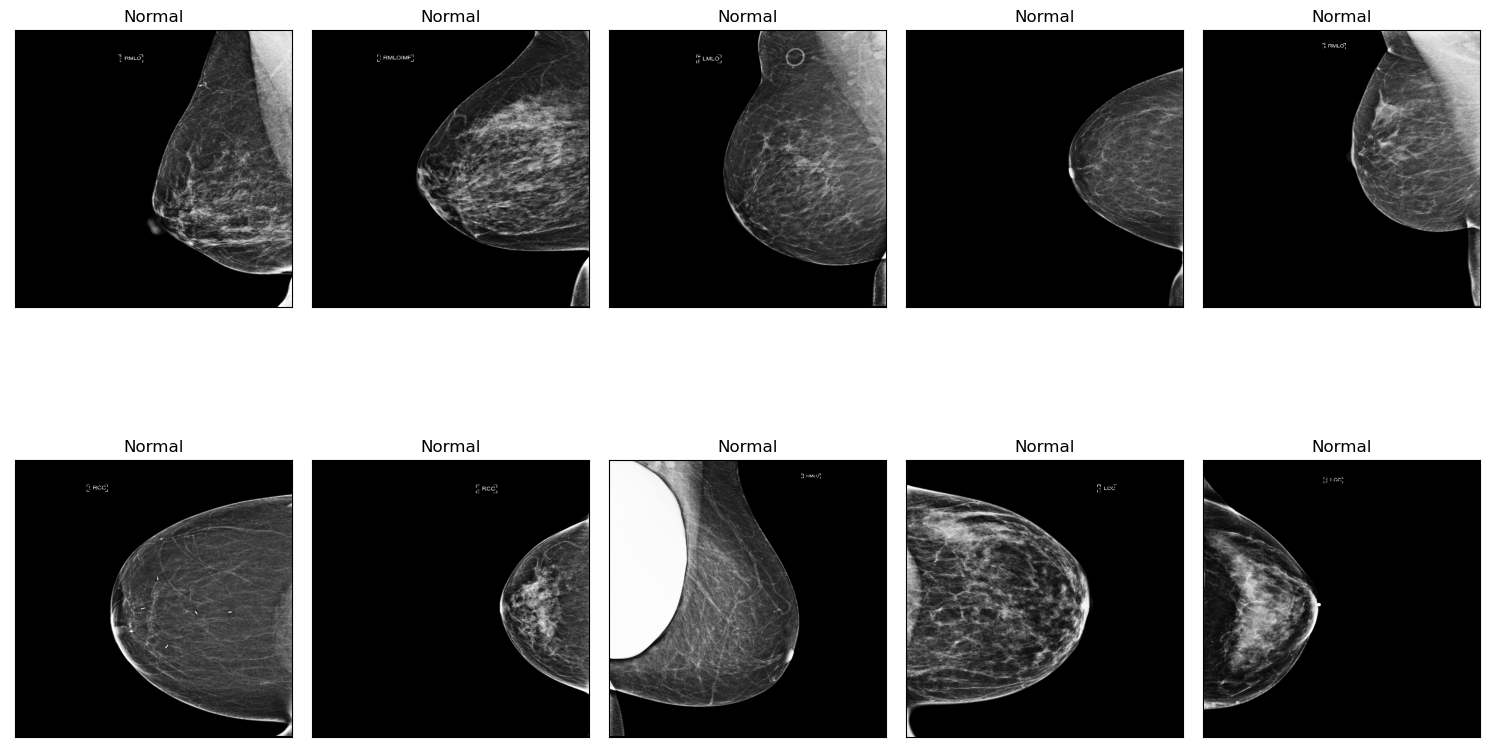

In [ ]:
# See normal images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()    

plt.show()

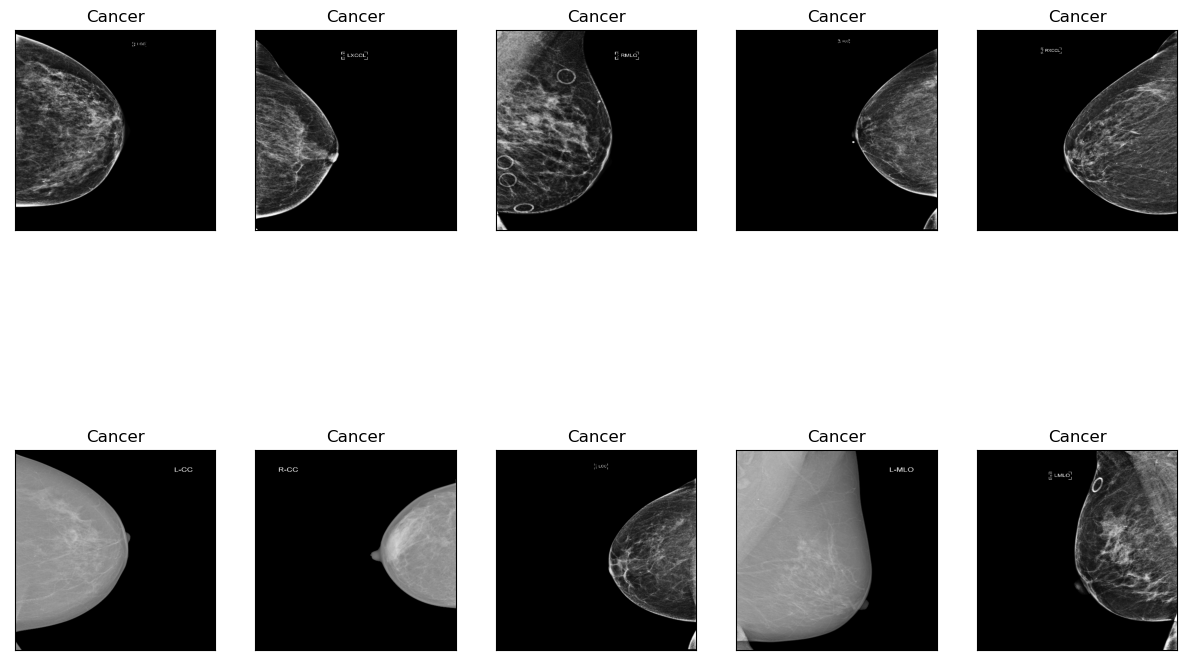

In [ ]:
# See cancer images from the training dataset.
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
    
plt.show()

# Create Image data Generators

The dataset has already been divided into train and validation datasets, and each dataset includes normal and cancer image files. Thus, image data generators were easily created. 

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [ ]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (512, 512),
        batch_size = 16,
        class_mode = 'binary'
)

Found 1221 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Defining the Model (Transfer Learning)

Here, ResNet50V2 was employed as the base model for transfer learning. Sigmoid, adam, and binary cross entropy were selected for the final activation function, optimizer, and loss function, respectively.

In [ ]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

# Train the Model

The model was trained with the train and validation data. Early stopping was added to prevent overfitting. 

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 54s 2s/step - loss: 0.7479 - accuracy: 0.5328 - val_loss: 0.6684 - val_accuracy: 0.5913
Epoch 2/15
20/20 [==============================] - 42s 2s/step - loss: 0.6696 - accuracy: 0.6003 - val_loss: 0.6602 - val_accuracy: 0.6042
Epoch 3/15
20/20 [==============================] - 44s 2s/step - loss: 0.6374 - accuracy: 0.6250 - val_loss: 0.6545 - val_accuracy: 0.6074
Epoch 4/15
20/20 [==============================] - 44s 2s/step - loss: 0.6393 - accuracy: 0.6125 - val_loss: 0.6598 - val_accuracy: 0.5994
Epoch 5/15
20/20 [==============================] - 44s 2s/step - loss: 0.6477 - accuracy: 0.6391 - val_loss: 0.6505 - val_accuracy: 0.6186
Epoch 6/15
20/20 [==============================] - 44s 2s/step - loss: 0.6385 - accuracy: 0.6484 - val_loss: 0.6404 - val_accuracy: 0.6298
Epoch 7/15
20/20 [==============================] - 44s 2s/step - loss: 0.6262 - accuracy: 0.6594 - val_loss: 0.6457 - val_accuracy: 0.6138
Epoch 8/15
20/20 [==

# Save the Model

In [ ]:
model.save('mammography_pred_model.h5')

# Model Metrics

The accuracy and loss were calculated for both train and validation data in the model training process.

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

Text(0, 0.5, 'loss')

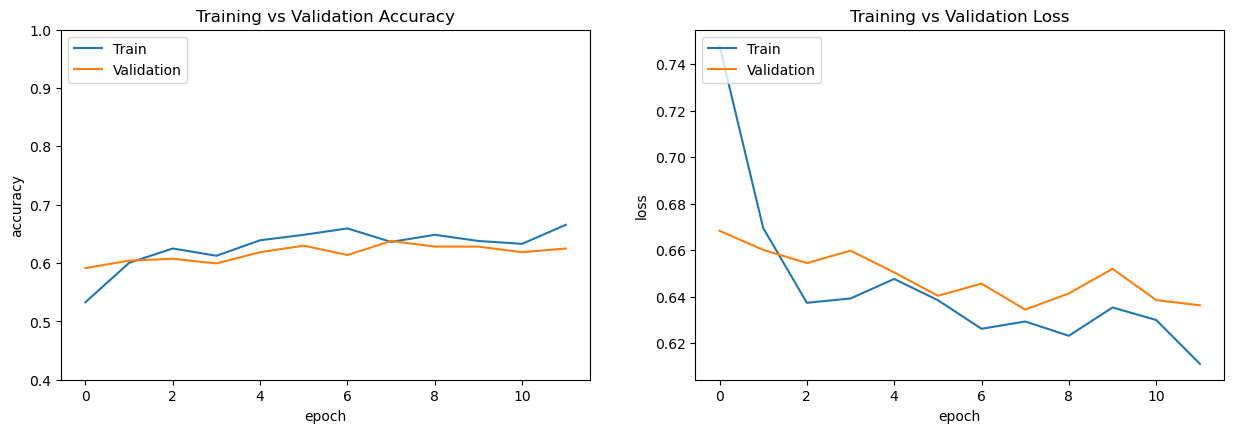

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

# Predictions

In order to evaluate the quality of the trained model, the outcome was predicted from the test (validation) data and compared with the observed value.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/mammography_pred_model.h5')

In [ ]:
pred = model.predict(validation_generator)

39/39 [==============================] - 8s 179ms/step


In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
print(y_pred)

[0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 

In [ ]:
pd.Series(y_pred).value_counts()

1    385
0    239
dtype: int64

# Confusion Matrix

Confusion matrix was created with the predicted and observed values. The matrix indicated almost correct predictions by the trained model except that there were two cases observed as false positive. False positive means that a case is actually negative but predicted as positive.

In [ ]:
cm = confusion_matrix(y_true, y_pred)

Text(50.722222222222214, 0.5, 'Truth')

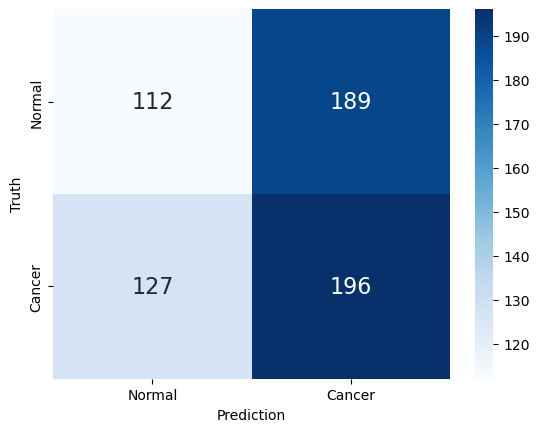

In [ ]:
# Define the class names.
class_names = ['Normal', 'Cancer']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

# Classification Report



In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.37      0.41       301
           1       0.51      0.61      0.55       323

    accuracy                           0.49       624
   macro avg       0.49      0.49      0.48       624
weighted avg       0.49      0.49      0.49       624



# Analysing the Results

It is crucial in the medical field to analyze what kinds of cases were misclassified by the AI model, because medical misdiagnosis must be avoided as much as possible. Thus, it is necessary to identify false positive and false negative cases. Making a data frame and confusion table can visualize the results. As discussed above, false negative cases must be particularly avoided.

In [ ]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [ ]:
print(confusion)

['TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP

In [ ]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,TN
1,FP
2,TN
3,FP
4,FP
...,...
619,FN
620,FN
621,TP
622,TP


In [ ]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,0,0,TN
1,1,0,FP
2,0,0,TN
3,1,0,FP
4,1,0,FP
...,...,...,...
619,0,1,FN
620,0,1,FN
621,1,1,TP
622,1,1,TP


In [ ]:
confusion_table.Results == 'FP'

0      False
1       True
2      False
3       True
4       True
       ...  
619    False
620    False
621    False
622    False
623    False
Name: Results, Length: 624, dtype: bool

In [ ]:
# list of false positive images
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
1,1,0,FP
3,1,0,FP
4,1,0,FP
5,1,0,FP
9,1,0,FP
...,...,...,...
289,1,0,FP
293,1,0,FP
295,1,0,FP
296,1,0,FP


In [ ]:
FPs.index

Int64Index([  1,   3,   4,   5,   9,  11,  12,  13,  14,  16,
            ...
            279, 281, 282, 283, 284, 289, 293, 295, 296, 297],
           dtype='int64', length=189)

In [ ]:
# list of false negative images
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
305,0,1,FN
306,0,1,FN
307,0,1,FN
308,0,1,FN
309,0,1,FN
...,...,...,...
617,0,1,FN
618,0,1,FN
619,0,1,FN
620,0,1,FN


In [ ]:
FNs.index

Int64Index([305, 306, 307, 308, 309, 313, 316, 321, 323, 324,
            ...
            605, 607, 609, 610, 614, 617, 618, 619, 620, 623],
           dtype='int64', length=127)

# Misclassficiation Cases

It is important to pick up wrong cases judged by the AI and to analyze why the AI made wrong judgements for these images.

In [ ]:
import glob
val_images = glob.glob('/kaggle/working/val/*/*.png')

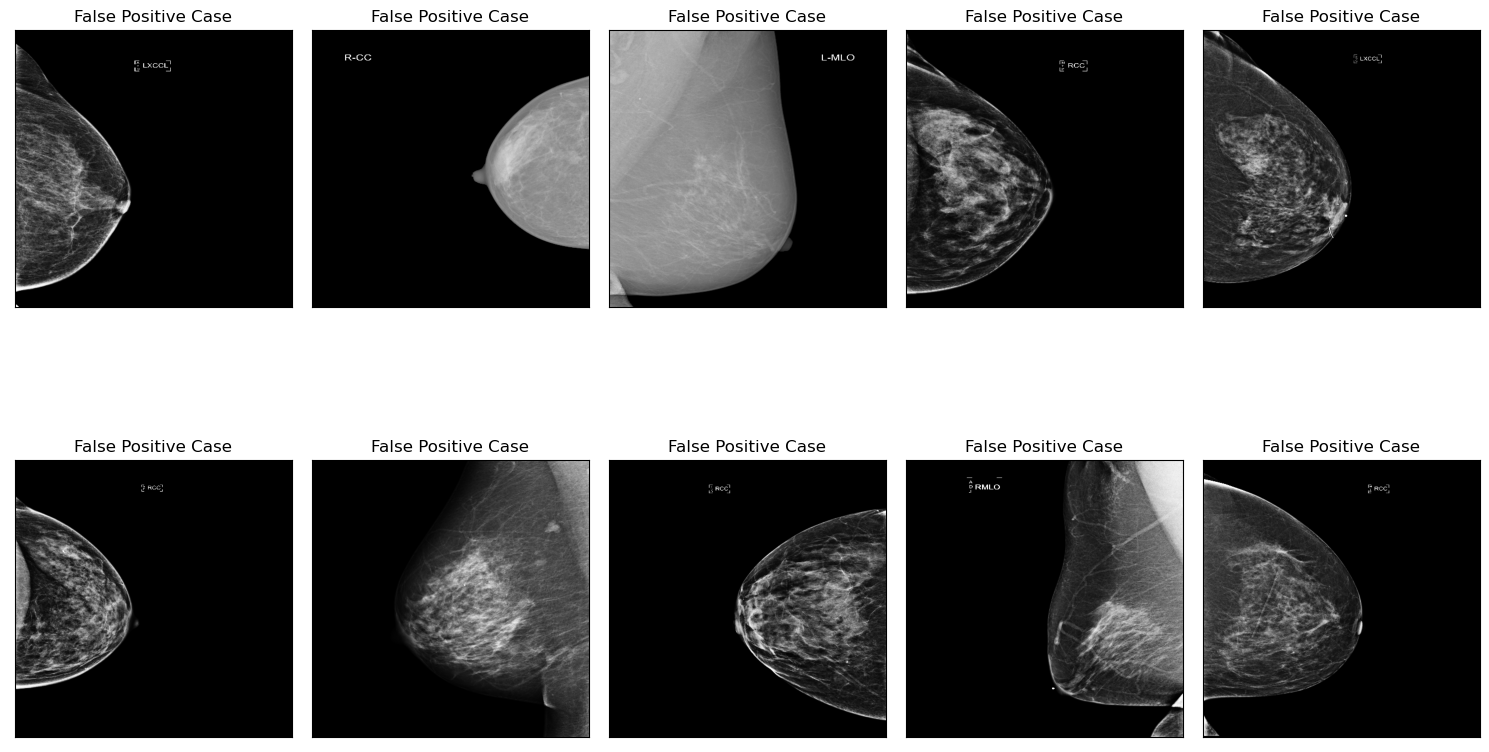

In [ ]:
# False positive imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

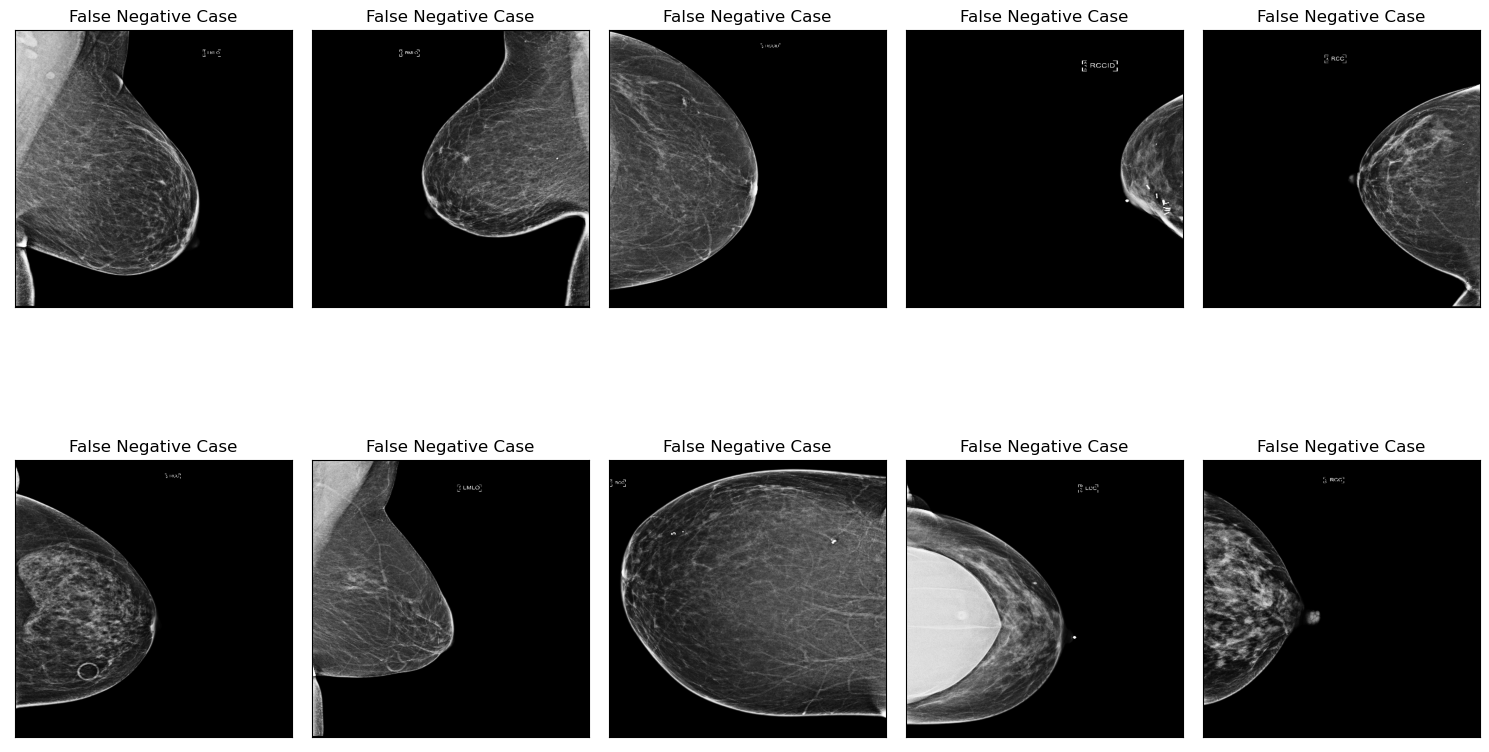

In [ ]:
# False negative imgages
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

# Finetuning the Model (Unfreeying the Layers of the Model)

In [ ]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)

for layer in base_model.layers:
    layer.trainable = True # Change from False to True.
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_____________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15
20/20 [==============================] - 77s 2s/step - loss: 0.6945 - accuracy: 0.5562 - val_loss: 110184.9844 - val_accuracy: 0.5176
Epoch 2/15
20/20 [==============================] - 47s 2s/step - loss: 0.6872 - accuracy: 0.5781 - val_loss: 600.1952 - val_accuracy: 0.4824
Epoch 3/15
20/20 [==============================] - 47s 2s/step - loss: 0.6867 - accuracy: 0.5875 - val_loss: 591.0364 - val_accuracy: 0.4824
Epoch 4/15
20/20 [==============================] - 46s 2s/step - loss: 0.6731 - accuracy: 0.6069 - val_loss: 156.9511 - val_accuracy: 0.5176
Epoch 5/15
20/20 [==============================] - 45s 2s/step - loss: 0.6693 - accuracy: 0.6166 - val_loss: 409.1920 - val_accuracy: 0.5176
Epoch 6/15
20/20 [==============================] - 47s 2s/step - loss: 0.6643 - accuracy: 0.5875 - val_loss: 58.7794 - val_accuracy: 0.4824
Epoch 7/15
20/20 [==============================] - 46s 2s/step - loss: 0.6592 - accuracy: 0.6150 - val_loss: 0.7474 - val_accuracy: 0.5513
Epoch 

In [ ]:
# This time we use validation data to calculate the final accuracy.
final_accuracy = model.evaluate_generator(validation_generator)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [ ]:
final_accuracy

0.5592948794364929

# Model Metrics

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualizing Accuracy and Loss

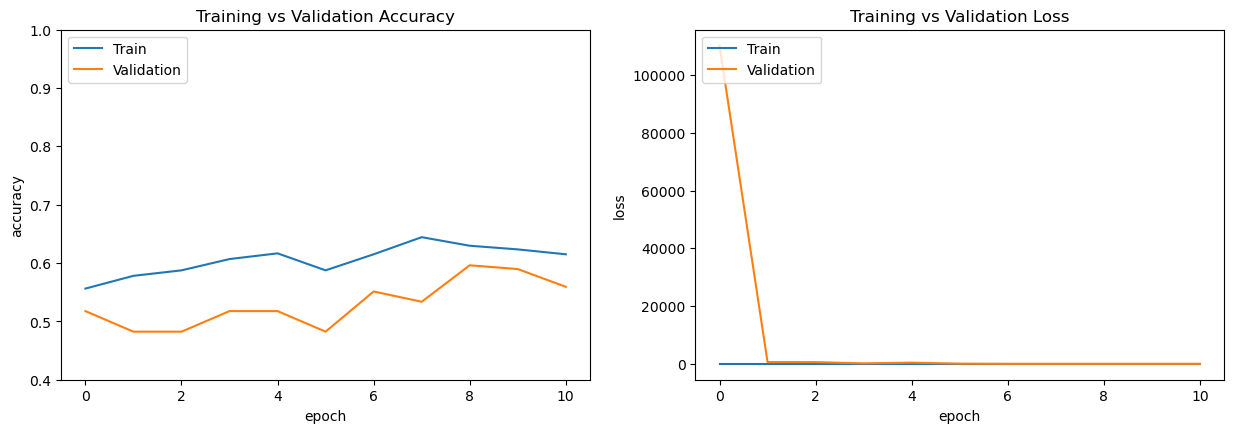

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

Analysis: We figured that Finetuning is worse than Transfer Learning, because the number of data images is small.

# Save the Model

In [ ]:
model.save('mammography_pred_model_finetuning.h5')

# Conclusion

This AI model may be useful for general physicians who occasionally see female patients for the screening purpose. Further improvement is required to prevent misdiagnosis and unnecessary treatment.